In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Problem2

In [2]:
X = pd.read_csv('Bayes_classifier/X.csv', header=None)
y = pd.read_csv('Bayes_classifier/y.csv', header=None)
y.columns = ['target']
data_nb = pd.concat([X, y], axis=1)
print("Shape of X: ", X.shape)
print("Shape of y: ", y.shape)
print("Shape of data: ", data_nb.shape)
print("Distribution of label: \n", y.value_counts())

Shape of X:  (4600, 54)
Shape of y:  (4600, 1)
Shape of data:  (4600, 55)
Distribution of label: 
 target
0         2787
1         1813
dtype: int64


In [3]:
### Shffule Dataframe
data_temp = data_nb.sample(frac=1, random_state=42).reset_index().iloc[:,1:]
### Partition Data
data_cv = np.array_split(data_temp, 10)

In [4]:
class Naive_Bayers:
    def __init__(self) -> None:
        None

    def fit(self, X, y):
        self.n, self.m = X.shape
        self.pi = y.sum()/y.shape[0]
        self.lambda_0 = (1 + X[y == 0].sum(axis = 0))/(1 + y.shape[0] - y.sum())
        self.lambda_0 = self.lambda_0
        self.lambda_1 = (1 + X[y == 1].sum(axis = 0))/(1 + y.sum())
        self.lambda_1 = self.lambda_1
    
    def predict(self, X):
        # print('X: ', X.shape)
        # print('lambda0: ', self.lambda_0.shape)
        # print(np.sum(X*np.log(self.lambda_1.T), axis=1))

        p0 = (np.log(1-self.pi) + np.sum(X*np.log(self.lambda_0.T), axis=1) - np.sum(self.lambda_0)).reset_index(drop=True)
        p1 = (np.log(self.pi) + np.sum(X*np.log(self.lambda_1.T), axis=1) - np.sum(self.lambda_1)).reset_index(drop=True)
        result = pd.Series([0 if p0[i] > p1[i] else 1 for i in range(len(p0))])
        return result
    
    def confusion_matrix(self, y_true, y_predict):
        y_true = y_true.reset_index(drop=True)
        y_TP = ((y_true == 1) & (y_predict == 1)).sum()

        y_TN = ((y_true == 0) & (y_predict == 0)).sum()
        y_FP = ((y_true == 0) & (y_predict == 1)).sum()
        y_FN = ((y_true == 1) & (y_predict == 0)).sum()
        return y_TP, y_TN, y_FP, y_FN
    
    def get_lambda(self):
        return self.lambda_0, self.lambda_1

### (a)

In [5]:
y_TP, y_TN, y_FP, y_FN = 0, 0, 0, 0
for i in range(10):
    X_train = pd.concat(data_cv[:i]+data_cv[i+1:10]).iloc[:,:-1]
    y_train = pd.concat(data_cv[:i]+data_cv[i+1:10]).iloc[:,-1]
    X_test = data_cv[i].iloc[:,:-1]
    y_test = data_cv[i].iloc[:,-1]
    nb_model = Naive_Bayers()
    nb_model.fit(X_train, y_train)
    predicted_result = nb_model.predict(X_test)
    TP, TN, FP, FN = nb_model.confusion_matrix(y_test, predicted_result)
    y_TP += TP
    y_TN += TN
    y_FP += FP
    y_FN += FN

print('-------------------------------------\n'
      ,'              Actual 1   '+'   Actual 0  \n'
      ,'Predicted 1     {0}            {1} \n Predicted 0      {2}             {3} \n-------------------------------------'
      .format(y_TP, y_FP, y_FN, y_TN ))


-------------------------------------
               Actual 1      Actual 0  
 Predicted 1     1714            490 
 Predicted 0      99             2297 
-------------------------------------


### (b)

In [6]:
lambda0, lambda1 = 0, 0
for i in range(10):
    X_train = pd.concat(data_cv[:i]+data_cv[i+1:10]).iloc[:,:-1]
    y_train = pd.concat(data_cv[:i]+data_cv[i+1:10]).iloc[:,-1]
    X_test = data_cv[i].iloc[:,:-1]
    y_test = data_cv[i].iloc[:,-1]
    nb_model = Naive_Bayers()
    nb_model.fit(X_train, y_train)
    l0, l1 = nb_model.get_lambda()
    lambda0 += l0
    lambda1 += l1
lambda0 /= 10
lambda1 /= 10

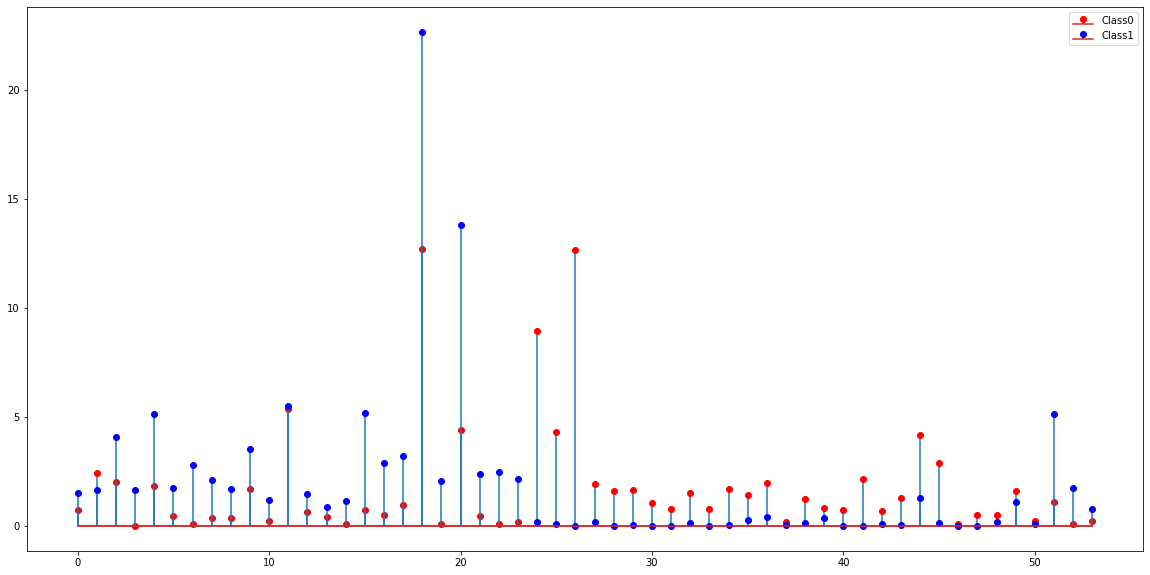

In [7]:
fig = plt.figure(figsize=(20,10))
plt.stem(lambda0.index, lambda0, label='Class0', markerfmt='ro')
plt.stem(lambda0.index, lambda1, label='Class1', markerfmt='bo')
plt.legend()
plt.show()

In feature 16 and 52 both have a higher value of lambda in class 1 and much lower value of lambda in class0, which means that the email contains "free" and "!" has a higher chance to be classified as a spam email.

In [8]:
# Feature16
print('Feature 16: Free, ', 'Class 0: ', lambda0[15], 'Class 1: ', lambda1[15])
# Feature52
print('Feature 52: !, ', 'Class 0: ', lambda0[51], 'Class 1: ', lambda1[51])

Feature 16: Free,  Class 0:  0.7395760282588606 Class 1:  5.214005750110287
Feature 52: !,  Class 0:  1.0961513031345622 Class 1:  5.128924515960302


### (c)

In [9]:
X = pd.read_csv('Bayes_classifier/X.csv', header=None)
y = pd.read_csv('Bayes_classifier/y.csv', header=None)
y.columns = ['target']

y['target'] = y.replace({0:-1})
X = pd.concat([X, pd.DataFrame(np.ones(X.shape[0]))], axis=1)
data_nb = pd.concat([X, y], axis=1)

### Shffule Dataframe
data_temp = data_nb.sample(frac=1, random_state=42).reset_index().iloc[:,1:]
data_cv = np.array_split(data_temp, 10)

In [83]:
class Logistic_Regression:
    def __init__(self, learning_rate = 0.001, n_iter = 1000):
        self.lr = learning_rate
        self.n_iter = n_iter
        self.weight = None
        self.bias = None
    
    def sigmoid(self, z):
        return 1/(1+np.exp(-z))
    
    def likelihood(self, X, y):
        h = self.sigmoid(y * (X@self.weight))
        return np.sum(np.log(h))
    
    def ascent(self, X, y):
        n = X.shape[0]
        h = self.sigmoid(y * (X@self.weight))
        likelihood_list = []
        for _ in range(self.n_iter):
            gradient = X.T @ (y * (1- h))/n
            self.weight += self.lr*gradient
            likehood_value = self.likelihood(X, y)
            likelihood_list.append(likehood_value)

        return likelihood_list
    
    def fit(self, X, y, method = 'ascent'):
        
        X = np.array(X)
        y = np.array(y).reshape(-1,1)
        self.weight = np.zeros((X.shape[1], 1))
        if method == 'ascent':
            likelihood_list = self.ascent(X, y)
        elif method == 'newton':
            likelihood_list = self.newton_method(X, y)
        return likelihood_list
    

    def predict(self, X):
        prob = self.sigmoid(X@self.weight)
        prob = prob.squeeze().reset_index(drop=True)
        result = pd.Series([1 if prob[i] > 0.5 else -1 for i in range(len(prob))])
        return result
    
    def accuracy(self, y_true, y_predict):
        y_true = pd.Series(y_true).reset_index(drop=True)
        y_predict = pd.Series(y_predict).reset_index(drop=True)
        return np.sum(y_true == y_predict)/len(y_true)
    
    def hessian(self, X, y):
        # X = np.array(X)
        # y = np.array(y).reshape(-1,1)
        # h = np.array(self.sigmoid(y * (X@self.weight)))
        h = self.sigmoid(y * (X@self.weight))
        D = np.diag(np.diag(h*(1-h.T)))
        return X.T@D@X
    
    def newton_method(self,X, y):
        n = X.shape[0]
        h = self.sigmoid(y * (X@self.weight))
        likelihood_list = []
        for _ in range(self.n_iter):
            hessian = self.hessian(X, y)
            gradient = X.T @ (y * (1- h))/n
            self.weight += self.lr*np.linalg.inv(hessian)@gradient
            likehood_value = self.likelihood(X, y)
            likelihood_list.append(likehood_value)

        return likelihood_list
    
    def confusion_matrix(self, y_true, y_predict):
        y_true = y_true.reset_index(drop=True)
        y_TP = ((y_true == 1) & (y_predict == 1)).sum()

        y_TN = ((y_true == -1) & (y_predict == -1)).sum()
        y_FP = ((y_true == -1) & (y_predict == 1)).sum()
        y_FN = ((y_true == 1) & (y_predict == -1)).sum()
        return y_TP, y_TN, y_FP, y_FN
    

In [77]:
### For test
i=0
X_train = pd.concat(data_cv[:i]+data_cv[i+1:10]).iloc[:,:-1]
y_train = pd.concat(data_cv[:i]+data_cv[i+1:10]).iloc[:,-1]
X_test = data_cv[i].iloc[:,:-1]
y_test = data_cv[i].iloc[:,-1]
nb_model = Logistic_Regression(learning_rate = 0.01/4600, n_iter = 100)
likelihood = nb_model.fit(X_train, y_train, 'newton')
y_predicted = nb_model.predict(X_test)
print(nb_model.accuracy(y_test, y_predicted))

0.8760869565217392


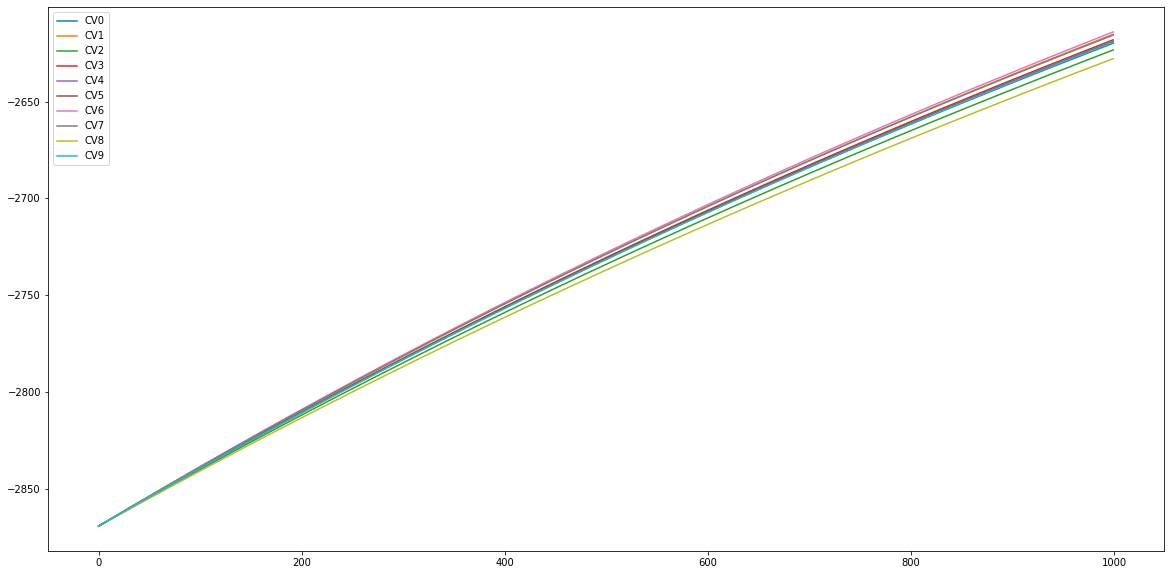

Accuracy:  0.8221739130434782


In [11]:
likelihood_list = []
accuracy = 0
fig = plt.figure(figsize=(20,10))
for i in range(10):
    X_train = pd.concat(data_cv[:i]+data_cv[i+1:10]).iloc[:,:-1]
    y_train = pd.concat(data_cv[:i]+data_cv[i+1:10]).iloc[:,-1]
    X_test = data_cv[i].iloc[:,:-1]
    y_test = data_cv[i].iloc[:,-1]
    nb_model = Logistic_Regression(learning_rate = 0.01/4600, n_iter = 1000)
    likelihood = nb_model.fit(X_train, y_train)
    y_predicted = nb_model.predict(X_test)
    plt.plot(range(len(likelihood)), likelihood, label='CV{0}'.format(i))
    accuracy += nb_model.accuracy(y_test, y_predicted)
    likelihood_list.append(likelihood)
plt.legend()
plt.show()
print('Accuracy: ', accuracy/10)


In [ ]:
y_TP, y_TN, y_FP, y_FN = 0, 0, 0, 0
for i in range(10):
    X_train = pd.concat(data_cv[:i]+data_cv[i+1:10]).iloc[:,:-1]
    y_train = pd.concat(data_cv[:i]+data_cv[i+1:10]).iloc[:,-1]
    X_test = data_cv[i].iloc[:,:-1]
    y_test = data_cv[i].iloc[:,-1]
    nb_model = Naive_Bayers()
    nb_model.fit(X_train, y_train)
    predicted_result = nb_model.predict(X_test)
    TP, TN, FP, FN = nb_model.confusion_matrix(y_test, predicted_result)
    y_TP += TP
    y_TN += TN
    y_FP += FP
    y_FN += FN

print('-------------------------------------\n'
      ,'              Actual 1   '+'   Actual 0  \n'
      ,'Predicted 1     {0}            {1} \n Predicted 0      {2}             {3} \n-------------------------------------'
      .format(y_TP, y_FP, y_FN, y_TN ))

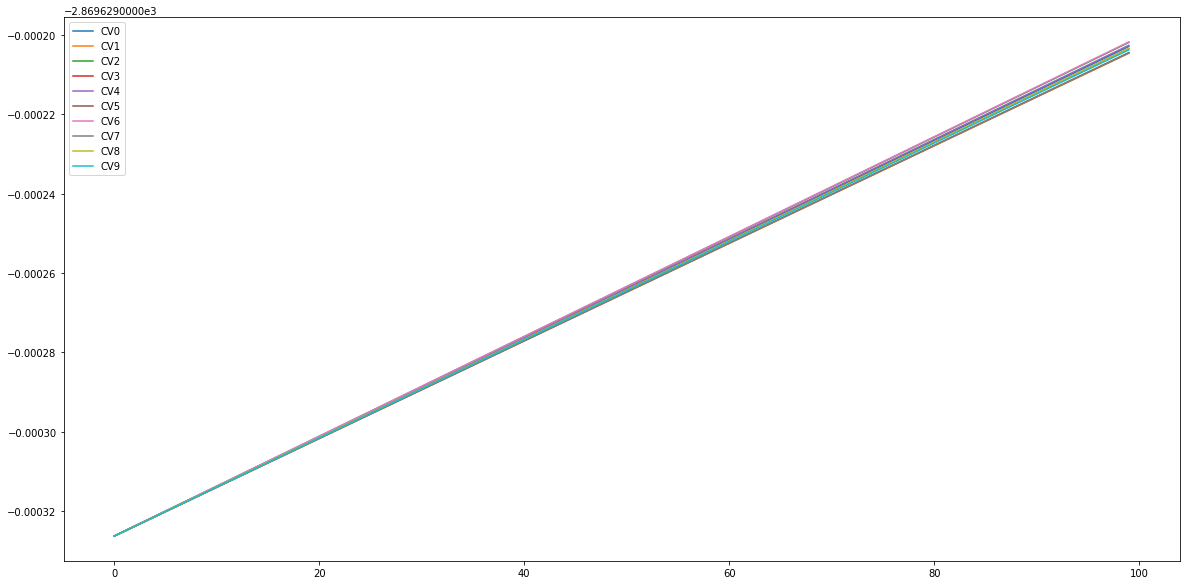

Accuracy:  0.8843478260869565
-------------------------------------
               Actual 1      Actual 0  
 Predicted 1     1415            134 
 Predicted 0      398             2653 
-------------------------------------


In [85]:
likelihood_list = []
accuracy = 0
fig = plt.figure(figsize=(20,10))
y_TP, y_TN, y_FP, y_FN = 0, 0, 0, 0
for i in range(10):
    X_train = pd.concat(data_cv[:i]+data_cv[i+1:10]).iloc[:,:-1]
    y_train = pd.concat(data_cv[:i]+data_cv[i+1:10]).iloc[:,-1]
    X_test = data_cv[i].iloc[:,:-1]
    y_test = data_cv[i].iloc[:,-1]
    nb_model = Logistic_Regression(learning_rate = 0.01/4600, n_iter = 100)
    likelihood = nb_model.fit(X_train, y_train, 'newton')
    y_predicted = nb_model.predict(X_test)
    plt.plot(range(len(likelihood)), likelihood, label='CV{0}'.format(i))
    accuracy += nb_model.accuracy(y_test, y_predicted)
    likelihood_list.append(likelihood)
    TP, TN, FP, FN = nb_model.confusion_matrix(y_test, y_predicted)
    y_TP += TP
    y_TN += TN
    y_FP += FP
    y_FN += FN

plt.legend()
plt.show()
print('Accuracy: ', accuracy/10)

print('-------------------------------------\n'
      ,'              Actual 1   '+'   Actual 0  \n'
      ,'Predicted 1     {0}            {1} \n Predicted 0      {2}             {3} \n-------------------------------------'
      .format(y_TP, y_FP, y_FN, y_TN ))